# <span style="color:#0b486b">  FIT3181: Deep Learning (2021)</span>
***
*CE/Lecturer:*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Head TA:*  **Mr Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
*Tutor:* **Dr Van Nguyen**  \[van.nguyen1@monash.edu \] | **Mr James Tong** \[james.tong1@monash.edu\] | **Dr Mahmoud Mohammad** \[mahmoud.hossam@monash.edu\]
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***


# <span style="color:#0b486b">Tutorial 5c - Additional Reading: Convolutional Neural Network with MiniVGG in TensorFlow 1.x.</span><span style="color:red;  font-size: 18px">** (additional code for your reference)</span>
**This tutorial applies CNN to a more real-world setting using TensorFlow using the `CIFAR-10` dataset. It will cover the following**:
1. ***How to implement a simple CNN to classify the `CIFAR-10` dataset using TF 1.x.***
2. ***How to implement a simplified version of a real-world CNN named `MiniVGG` to classify the `CIFAR-10` dataset using TF 1.x.***

VGGNet, (aka VGG), was first introduced by Simonyan and Zisserman in their 2014 paper, *Very Deep Learning Convolutional Neural Networks for Large-Scale Image Recognition*. 
The work was the first to demonstrate that architecture with very small (3×3) filters can be successfully trained for very deep networks (16-19 layers) and obtain state-of-the-art classification on the challenging ImageNet classification challenge. <br/>

The VGG family of Convolutional Neural Networks can be characterized by two key components:
1. *All CONV layers in the network using only **3×3** filters.*
2. *Stacking multiple CONV => RELU layer sets (where the number of consecutive CONV => RELU layers normally increases as we go deeper) before applying a POOL operation.* <br/>

Due to the size of this architecture which compromises the running time, this tutorial will use `MiniVGG` which is a simplified version of `VGG` including its architecture, implementation, and application to the `CIFAR-10` dataset.

---

## <span style="color:#0b486b">I. A Simple CNN for the CIFAR-10 dataset</span> ##

### <span style="color:#0b486b">I.1. The architecture of a Simple CNN</span>

We are going to implement a simple CNN to work on the `CIFAR-10` dataset. This simple CNN includes `convolutional` and `pooling` layers and applies the `dropout` technique at the fully connected layer. The specification of this network is as follows:

<img src='images/SimpleCNN_Table.PNG' align='center' width=300/>

### <span style="color:#0b486b">I.2. Implementation of a Simple CNN </span>

#### <span style="color:#0b486b">I.2.1. Import Necessary Libraries and Modules</span> ####
We import the necessary modules and libraries.

In [1]:
import os
import pickle
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


#### <span style="color:#0b486b">I.2.2. The Class for Data Processing</span> ####
The `CifarLoader` class supports us to load and process the `CIFAR-10` dataset which has been stored in the `pickle` format on the hard disk. 

Download CIFAR-10 dataset at https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract files to `cifar10_data` folder.

In [2]:
DATA_PATH = "./cifar10_data/cifar-10-batches-py"

In [3]:
class CifarLoader(object):
    def __init__(self, source_files):
        self._source= source_files
        self._i=0
        self.images= None
        self.labels= None
        
    def load(self):
        data= [unpickle(f) for f in self._source]
        images= np.vstack([d['data'] for d in data])
        n= len(images)
        self.images= images.reshape([n,3,32,32]).transpose(0,2,3,1).astype('float')/255.0
        self.labels= one_hot(np.hstack([d['labels'] for d in data]), 10)
        return self
    
    def next_batch(self, batch_size):
        idx = np.random.choice(self.images.shape[0], batch_size, replace=batch_size > self.images.shape[0])
        x = self.images[idx]
        y = self.labels[idx]
        return x,y

In [4]:
def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        dict= pickle.load(fo, encoding ='latin1')
        return dict

In [5]:
def one_hot(vec, vals=10):
    n = len(vec)
    out= np.zeros([n, vals])
    out[range(n), vec]=1
    return out

In [6]:
class CifarDataManager(object):
    def __init__(self):
        self.train= CifarLoader(['data_batch_{}'.format(i) for i in range(1,5)]).load()
        self.valid= CifarLoader(['data_batch_5']).load()
        self.test= CifarLoader(['test_batch']).load()

We now test the `CifarLoader` class.

In [7]:
def display_cifar(images, size):
    n= len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im= np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)]) for j in range(size)])
    plt.imshow(im)
    plt.show()

In [8]:
d= CifarDataManager()

Create a tiny `CIFAR-10` for a demonstration.

In [9]:
n_train, n_valid, n_test = 5000, 5000, 5000 
d.train.images = d.train.images[:n_train]
d.train.labels = d.train.labels[:n_train]
d.valid.images = d.valid.images[:n_valid]
d.valid.labels = d.valid.labels[:n_valid]
d.test.images = d.test.images[:n_test]
d.test.labels = d.test.labels[:n_test]

In [10]:
print("# Training images: {}".format(len(d.train.images)))
print("# Training labels: {}".format(len(d.train.labels)))
print("# Validation images: {}".format(len(d.valid.images)))
print("# Validation labels: {}".format(len(d.valid.labels)))
print("# Test images: {}".format(len(d.test.images)))
print("# Test labels: {}".format(len(d.test.labels)))

# Training images: 5000
# Training labels: 5000
# Validation images: 5000
# Validation labels: 5000
# Test images: 5000
# Test labels: 5000


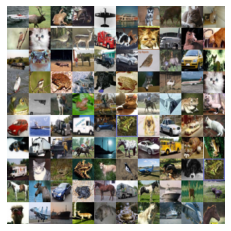

In [11]:
display_cifar(d.train.images,10)

#### <span style="color:#0b486b">I.2.3. Class Layers </span> ####
Class `Layers` contains `staticmethod` regarding layers used in the `MiniVGG` network. You can find these built-in layers in the contribution <a href='https://www.tensorflow.org/api_docs/python/tf/contrib/layers'>`tf.contrib.layers`</a> and use this in your code. However, in the tutorial, we implement these basic layers from scratch.

    
- Layer `dense`: this represents a fully connected layer. This takes `inputs` as a 2-D tensor of the shape $[batch, input\_size]$ where $batch$ is the mini-batch size. The parameter `act` specifies the activation function in use if it is not set to `None`. A dense layer when declared will associate to two trainable variables: the weight matrix $W$ of the shape $[input\_size, output\_size]$ and the bias $b$ of the shape $[output\_size]$.

- Layer `conv2D`: this represents a 2-D convolutional layer. This takes `inputs` as a 4-D tensor of the shape $[batch, in\_height, in\_width, in\_channels]$ where $in\_height, in\_width$, and $in\_channels$ are the height, width, and depth of `inputs`. The `filter_shape` is a 4-D tensor of the shape $[filter\_height, filter\_width, in\_channels, out\_channels]$ where $out\_channels$ specifies the number of output channels. Consequently, the output of `conv2D` is another 4-D tensor with the depth to be $out\_channels$. In addition, the parameter `strides` helps us to work out the output height and width.

- Layer `max_pool`: this represents the max pooling layer used to downsample images. For instance, by setting $strides=[1,2,2,1]$, $kSize= [1,2,2,1]$, and $padding="SAME"$, we downsample input image by twice.

In [12]:
class Layers:
    @staticmethod
    def dense(inputs, output_size, name="dense1", act=None):
        with tf.name_scope(name):
            input_size= int(inputs.get_shape()[1])
            W_init = tf.random.normal([input_size, output_size], mean=0, stddev= 0.1, dtype= tf.float32)
            b_init= tf.random.normal([output_size], mean=0, stddev= 0.1, dtype= tf.float32)
            W= tf.Variable(W_init, name= "W")
            b= tf.Variable(b_init, name="b")
            Wxb= tf.matmul(inputs, W) + b
            if act is None:
                return Wxb
            else:
                return act(Wxb)

    @staticmethod
    def conv2D(inputs, filter_shape, strides=[1,1,1,1], padding="SAME", name= "conv1", act=None):
        with tf.name_scope(name):
            W_init= tf.random.normal(filter_shape, mean=0, stddev=0.1, dtype= tf.float32)
            W= tf.Variable(W_init, name="W")
            b_init= tf.random.normal([int(filter_shape[3])], mean=0, stddev=0.1, dtype= tf.float32)
            b= tf.Variable(b_init, name="b")
            Wxb= tf.nn.conv2d(input= inputs, filter= W, strides= strides, padding= padding)+b
            if act is None:
                return Wxb
            else:
                return act(Wxb)
            
    @staticmethod
    def max_pool(inputs, ksize=[1,2,2,1],strides=[1,2,2,1], padding="SAME"):
        return tf.nn.max_pool(value= inputs, ksize=ksize, strides= strides, padding= padding)
    
    @staticmethod
    def dropout(inputs, drop_rate):
        return tf.nn.dropout(inputs, rate= drop_rate)
    
    @staticmethod
    def batch_norm(inputs, phase_train):
        return tf.layers.batch_normalization(inputs, momentum= 0.90, training=phase_train, center= True, scale=True)

#### <span style="color:#0b486b">I.2.4. Class SimpleCNN </span> ####
The `SimpleCNN` class represents a `CNN` network and includes the following methods:
- Method `build` contains the code to build a computational graph for  a `SimpleCNN` network. After invoking this method, the computational graph of `SimpleCNN` is conducted and stored in the main memory.
- Method `partial_fit` represents how to feed a mini-batch to our network at each iteration. This method is invoked to train our network.
- Method `predict` is used to predict labels for a given dataset $X$. It renders the predicted labels of the data points in $X$ and the corresponding accuracy.
- Method `compute_acc_loss` returns the loss and accuracy of a given dataset $X$ with labels $y$.

In [13]:
class SimpleCNN():
    def __init__(self, width=32, height=32, depth=3, num_classes=4, drop_rate= 0.3, batch_size=10, 
                 epochs= 5, optimizer= tf.train.AdamOptimizer(learning_rate=0.01)):
        self.width= width
        self.height= height
        self.depth= depth
        self.num_classes= num_classes
        self.drop_rate= drop_rate
        self.batch_size= batch_size
        self.epochs= epochs
        self.optimizer= optimizer
        self.tf_graph= tf.Graph()
        self.session= tf.Session(graph= self.tf_graph)
    
    def build(self):
        with self.tf_graph.as_default():
            with tf.name_scope("simple_cnn"):
                self.X= tf.placeholder(shape=[None, self.height, self.width, self.depth], dtype=tf.float32)
                self.y= tf.placeholder(shape= [None, self.num_classes], dtype= tf.int64)
                self.drop_rate_holder= tf.placeholder(dtype= tf.float32)
                self.phase_train= tf.placeholder(dtype= tf.bool)
                conv1= Layers.conv2D(inputs=self.X, filter_shape=[5,5,3,32], act= tf.nn.relu)
                pool1= Layers.max_pool(conv1)
                conv2= Layers.conv2D(inputs=pool1, filter_shape=[5,5,32,64], act= tf.nn.relu)
                pool2= Layers.max_pool(conv2)
                flat_dim = pool2.get_shape().as_list()[1]*pool2.get_shape().as_list()[2]*pool2.get_shape().as_list()[3]     
                pool2_flat= tf.reshape(pool2, [-1, flat_dim])
                full1= Layers.dense(inputs= pool2_flat, output_size=1000, act= tf.nn.relu)
                full1_drop= Layers.dropout(inputs=full1, drop_rate=self.drop_rate_holder)
                self.logits= Layers.dense(inputs= full1_drop, output_size=self.num_classes)
            with tf.name_scope("train"):
                cross_entropy= tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits= self.logits)
                self.loss= tf.reduce_mean(cross_entropy)
                self.train_op = self.optimizer.minimize(self.loss)
            with tf.name_scope("predict"):
                self.y_pred= tf.argmax(self.logits, 1)
                corrections= tf.equal(self.y_pred, tf.argmax(self.y,1))
                self.accuracy= tf.reduce_mean(tf.cast(corrections, tf.float32))
            self.session.run(tf.global_variables_initializer())
    
    def partial_fit(self, X_batch, y_batch):
        self.session.run([self.train_op], feed_dict={self.X:X_batch, self.y:y_batch, 
                                                  self.drop_rate_holder: self.drop_rate, 
                                                  self.phase_train: True})
        
    def predict(self, X, y):
        y_pred, acc= self.session.run([self.y_pred, self.accuracy], feed_dict={self.X:X, self.y:y, 
                                                                               self.drop_rate_holder:0,
                                                                               self.phase_train: False})
        return y_pred, acc
        
    def compute_acc_loss(self, X, y):
        loss, acc = self.session.run([self.loss, self.accuracy], 
                                             feed_dict={self.X:X, self.y:y, self.drop_rate_holder:0, 
                                                        self.phase_train: False})
        return loss, acc
        
    def __exit__(self, exc_type, exc_value, traceback):
        self.session.close()
    

#### <span style="color:#0b486b">I.2.5. Training SimpleCNN on the CIFAR-10 dataset </span> ####
We now create an instance of the `SimpleCNN` class and train on the `CIFAR-10` dataset. The train, valid losses and accuracies are printed out at the end of each epoch. 

In [14]:
batch_size = 16
epochs = 5
num_classes = 10
training_size = len(d.train.images)
iter_per_epoch = int(training_size/batch_size) +1

In [15]:
network= SimpleCNN(batch_size=batch_size, epochs=epochs,
                   num_classes=num_classes, optimizer=tf.train.AdamOptimizer(learning_rate=0.001))

In [16]:
network.build()

In [17]:
for epoch in range(epochs):
    for i in range(iter_per_epoch):
        X_batch,y_batch= d.train.next_batch(batch_size)
        network.partial_fit(X_batch, y_batch)
        if i % 100==0:
            batch_loss, batch_acc= network.compute_acc_loss(X_batch, y_batch)
            print("Batch loss: {}, batch accuracy: {}".format(batch_loss, batch_acc))
    train_loss, train_acc= network.compute_acc_loss(d.train.images, d.train.labels)
    val_loss, val_acc= network.compute_acc_loss(d.valid.images, d.valid.labels)
    print("\nEpoch {}: train loss={}, val loss={}".format(epoch+1, train_loss, val_loss))
    print("######: train acc={}, val acc={}\n".format(train_acc, val_acc))
    #print(train_out, val_out)
print("Finish training and come to testing")
#print(d.test.labels.shape)
y_pred, acc= network.predict(d.test.images, d.test.labels)
print("Test accuracy= {}".format(acc))

Batch loss: 13.669562339782715, batch accuracy: 0.375
Batch loss: 1.6829237937927246, batch accuracy: 0.375
Batch loss: 1.481694221496582, batch accuracy: 0.5
Batch loss: 1.1397149562835693, batch accuracy: 0.75

Epoch 1: train loss=1.4886810779571533, val loss=1.7204673290252686
######: train acc=0.49619999527931213, val acc=0.4004000127315521

Batch loss: 1.9591422080993652, batch accuracy: 0.375
Batch loss: 1.7684681415557861, batch accuracy: 0.375
Batch loss: 1.6323034763336182, batch accuracy: 0.375
Batch loss: 0.706457257270813, batch accuracy: 0.875

Epoch 2: train loss=1.1245166063308716, val loss=1.605055332183838
######: train acc=0.6186000108718872, val acc=0.45260000228881836

Batch loss: 1.056199312210083, batch accuracy: 0.75
Batch loss: 1.0050225257873535, batch accuracy: 0.6875
Batch loss: 0.9311239719390869, batch accuracy: 0.6875
Batch loss: 0.6258769035339355, batch accuracy: 0.8125

Epoch 3: train loss=0.8193433880805969, val loss=1.5552418231964111
######: train ac

As can be observed, the training accuracy is 0.91, while the test accuracy is 0.66, indicating a sign of overfitting. In the implementation of MiniVGG, we use the bach normalization to mitigate the overfitting issue.

## <span style="color:#0b486b">II. MiniVGG for the CIFAR-10 dataset</span> ##

### <span style="color:#0b486b">II.1. Architecture of MiniVGG </span>
The following figure and table show the concrete architecture of `MiniVGG`. As mentioned before, `MiniVGG` only uses $3\times3$ filters. In addition, in the `MiniVGGNet`, we apply the batch norm technique to regularize the training and allow the network to be trained with a higher learning rate.

<img src='images/MiniVGG_Table.png' align='center' width=300/>

### <span style="color:#0b486b">II.2. Implementation of MiniVGG </span>

#### <span style="color:#0b486b">II.2.1. Class MiniVGGNet </span> ####
The `MiniVGG` class represents a `MiniVGG` network and includes the following methods:
- Method `build`contains the code to build a computational graph for  a `MiniVGGNet`. After invoking this method, the computational graph of `MiniVGGNet` is conducted and stored in the main memory.
- Method `partial_fit` represents how to feed a mini-batch to our network at each iteration. This method is invoked to train our network.
- Method `predict` is used to predict labels for a given dataset $X$. It renders the predicted labels of the data points in $X$ and the corresponding accuracy.
- Method `compute_acc_loss` returns the loss and accuracy of a given dataset $X$ with labels $y$.

In [18]:
class MiniVGGNet():
    def __init__(self, width=32, height=32, depth=3, num_classes=4, drop_rate= 0.3, batch_size=10, 
                 epochs= 20, optimizer= tf.train.AdamOptimizer(learning_rate=0.001)):
        self.width= width
        self.height= height
        self.depth= depth
        self.num_classes= num_classes
        self.drop_rate= drop_rate
        self.batch_size= batch_size
        self.epochs= epochs
        self.optimizer= optimizer
        self.tf_graph = tf.Graph()
        self.session= tf.Session(graph= self.tf_graph)
        
    def build(self):
        with self.tf_graph.as_default():
            with tf.name_scope("mini_vgg"):
                self.X= tf.placeholder(shape=[None, self.height, self.width, self.depth], dtype=tf.float32)
                self.y= tf.placeholder(shape= [None, self.num_classes], dtype= tf.int64)
                self.drop_rate_holder= tf.placeholder(dtype= tf.float32)
                self.phase_train= tf.placeholder(dtype= tf.bool)
                conv1= Layers.conv2D(inputs=self.X, filter_shape=[3,3,3,32], act= tf.nn.relu)
                bn1= Layers.batch_norm(conv1, self.phase_train)
                conv2= Layers.conv2D(bn1, [3,3,32,32], act= tf.nn.relu)
                bn2= Layers.batch_norm(conv2, self.phase_train)
                pool2= Layers.max_pool(bn2)
                pool2_drop= Layers.dropout(pool2, self.drop_rate_holder)
                conv3= Layers.conv2D(pool2_drop, [3,3,32,64], act= tf.nn.relu)
                bn3= Layers.batch_norm(conv3, self.phase_train)
                conv4= Layers.conv2D(bn3, [3,3,64,64], act= tf.nn.relu)
                bn4= Layers.batch_norm(conv4, self.phase_train)
                pool4= Layers.max_pool(bn4)
                pool4_drop= Layers.dropout(pool4, self.drop_rate_holder)
                pool4_flat= tf.reshape(pool4_drop,[-1, 8*8*64])
                full5= Layers.dense(pool4_flat, 512, act= tf.nn.relu)
                bn5= Layers.batch_norm(full5, self.phase_train)
                full5_drop= Layers.dropout(bn5, self.drop_rate_holder)
                self.logits= Layers.dense(full5_drop, self.num_classes)
            with tf.name_scope("train"):
                cross_entropy= tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits= self.logits)
                self.loss= tf.reduce_mean(cross_entropy)
                update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                with tf.control_dependencies(update_ops):
                    self.train_op = self.optimizer.minimize(self.loss)
            with tf.name_scope("predict"):
                self.y_pred= tf.argmax(self.logits, 1)
                corrections= tf.equal(self.y_pred, tf.argmax(self.y,1))
                self.accuracy= tf.reduce_mean(tf.cast(corrections, tf.float32))
            self.session.run(tf.global_variables_initializer())
    
    def partial_fit(self, X_batch, y_batch):
        self.session.run([self.train_op], feed_dict={self.X:X_batch, self.y:y_batch, 
                                                  self.drop_rate_holder: self.drop_rate, 
                                                  self.phase_train: True})
        
    def predict(self, X, y):
        y_pred, acc= self.session.run([self.y_pred, self.accuracy], feed_dict={self.X:X, self.y:y,
                                                                               self.drop_rate_holder:0,
                                                                              self.phase_train: False})
        return y_pred, acc
        
    def compute_acc_loss(self, X, y):
        loss, acc = self.session.run([self.loss, self.accuracy], 
                                             feed_dict={self.X:X, self.y:y, 
                                                        self.drop_rate_holder:0,
                                                        self.phase_train: False})
        return loss, acc
        
    def __exit__(self, exc_type, exc_value, traceback):
        self.session.close()
        

#### <span style="color:#0b486b">II.2.2. Training MiniVGG on the CIFAR-10 dataset </span> ####
We now create an instance of the `MiniVGGNet` class and train on the `CIFAR-10` dataset. The train, valid losses and accuracies are printed out at the end of each epoch. 

In [19]:
batch_size= 16
epochs= 5
num_classes= 10
training_size= len(d.train.images)
iter_per_epoch= int(training_size/batch_size) +1
network= MiniVGGNet(batch_size= batch_size, epochs= epochs, 
                    num_classes= num_classes, optimizer= tf.train.AdamOptimizer(learning_rate=0.001))
network.build()
for epoch in range(epochs):
    for i in range(iter_per_epoch):
        X_batch,y_batch= d.train.next_batch(batch_size)
        network.partial_fit(X_batch, y_batch)
        if i % 100==0:
            batch_loss, batch_acc= network.compute_acc_loss(X_batch, y_batch)
            print("Batch loss: {}, batch accuracy: {}".format(batch_loss, batch_acc))
    train_loss, train_acc= network.compute_acc_loss(d.train.images, d.train.labels)
    val_loss, val_acc= network.compute_acc_loss(d.valid.images, d.valid.labels)
    print("\nEpoch {}: train loss={}, val loss={}".format(epoch+1, train_loss, val_loss))
    print("######: train acc={}, val acc={}\n".format(train_acc, val_acc))
print("Finish training and come to testing")
y_pred, acc= network.predict(d.test.images, d.test.labels)
print("Test accuracy= {}".format(acc))

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\vngu0061\Anaconda3\envs\teaching\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
C:\Users\vngu0061\Anaconda3\envs\teaching\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Batch loss: 4.288486480712891, batch accuracy: 0.1875
Batch loss: 2.958160638809204, batch accuracy: 0.1875
Batch loss: 2.2365450859069824, batch accuracy: 0.4375
Batch loss: 1.8430627584457397, batch accuracy: 0.5

Epoch 1: train loss=2.203437566757202, val loss=2.4077587127685547
######: train acc=0.41819998621940613, val acc=0.3718000054359436

Batch loss: 1.7514631748199463, batch accuracy: 0.4375
Batch loss: 1.1763865947723389, batch accuracy: 0.6875
Batch loss: 1.7445464134216309, batch accuracy: 0.4375
Batch loss: 1.8973803520202637, batch accuracy: 0.3125

Epoch 2: train loss=2.361262083053589, val loss=2.6787049770355225
######: train acc=0.4519999921321869, val acc=0.38119998574256897

Batch loss: 5.070657730102539, batch accuracy: 0.625
Batch loss: 0.8092569708824158, batch accuracy: 0.625
Batch loss: 1.8242043256759644, batch accuracy: 0.4375
Batch loss: 1.4168049097061157, batch accuracy: 0.5

Epoch 3: train loss=1.6053978204727173, val loss=2.015657901763916
######: train

As you can observe, the gap between training and validating accuracies now is reduced to 0.05 (5%), implying that we can mitigate the overfitting issue, hence achieving better test accuracy 0.73 compared to 0.66 in the previous experiment.

## <span style="color:#0b486b">III. Additional Exercises</span> ##

1. Rewrite the `SimpleCNN` and `MiniVGGNet` classes  using the built-up layers in `tf.layers`.
2. Add code to visualize the train, test losses and accuracies.
3. Write code to visualize the filters of the trained `SimpleCNN` or `MiniVGG` networks.

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>